In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

current_dir = '/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainGauss'
print(current_dir)
if current_dir not in sys.path:
    sys.path.append(current_dir)

!pip install torcheval

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torcheval.metrics import MulticlassF1Score, MulticlassAUROC, MulticlassConfusionMatrix

import MHFN_batch
from MHFN_batch import MHFN_layer

from collections import defaultdict

/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainGauss
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
# fixing seeds for deterministic behaviour
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
n_per_class = 10
transform = transforms.ToTensor()

full_training = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

class_counts = defaultdict(int)
selected_indices = []

for idx, (img, label) in enumerate(full_training):
    if class_counts[label] < n_per_class:
        selected_indices.append(idx)
        class_counts[label] += 1
        #print(class_counts)
    if all(c >= n_per_class for c in class_counts.values()):
        break

training_data = Subset(full_training, selected_indices)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.49MB/s]


100


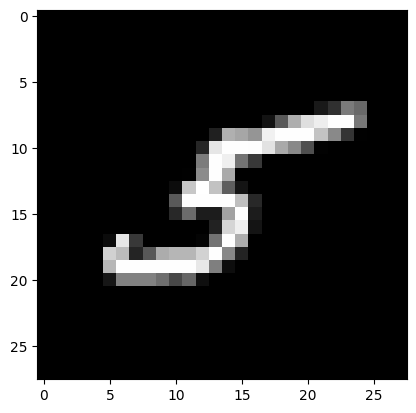

In [ ]:
print(len(training_data))
plt.imshow(training_data[99][0][0], cmap='gray')

In [ ]:
sup_pat = []
for i in range(len(training_data)):
    sup_pat.append(training_data[i][0][0])

sup_pat_tensor = torch.stack(sup_pat)

# plt.imshow(sup_pat[0][499], cmap='gray')
# print(sup_pat[0].shape)
#print(max(sup_pat[0].flatten()))
patterns = {i:sup_pat_tensor[i] for i in range(len(training_data))}
#plt.imshow(patterns[99], cmap='gray')

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean
        noisy = torch.clamp(noisy, 0., 1.)
        return noisy

transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.3)
])

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
    )

In [ ]:
train_loader = DataLoader(training_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

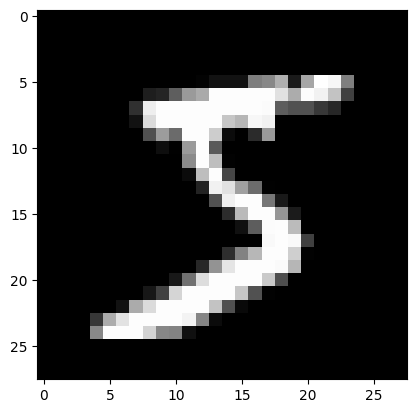

In [ ]:
plt.imshow(training_data[0][0][0], cmap='gray')

tensor(1.)


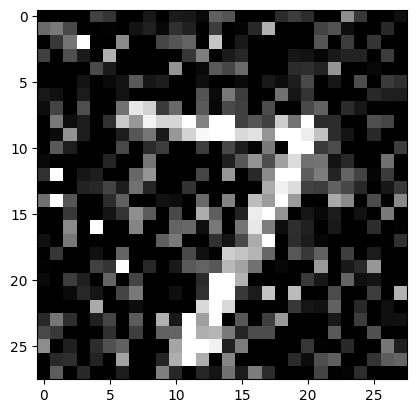

In [ ]:
plt.imshow(test_data[0][0][0], cmap='gray')
print(max(test_data[0][0][0].flatten()))

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self, patterns_dict, beta = 10):
        super().__init__()
        self.input_reconstructor = MHFN_batch.MHFN_layer(patterns_dict=patterns_dict, beta=beta)
        self.feature_extractor = torch.nn.Sequential(
            self.make_block(2, 16),
            self.make_block(16, 32),
            self.make_block(32, 64),
            self.make_block(64, 128),
            self.make_block(128, 256),
            self.make_block(256, 256)
            # torch.nn.AvgPool2d(5),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(256, 10),
            #torch.nn.Softmax() torch.nn.CrossEntropyLoss already does that
        )

    def make_block(self, in_channels, out_channels):
        block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        # torch.nn.BatchNorm2d(out_channels),
        # torch.nn.ReLU(),
        # torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.Dropout(0.1),
        torch.nn.ReLU()
        )
        return block

    def forward(self, x):
        x_1 = self.input_reconstructor(x).detach()
        # print("NaNs in x_1:", torch.isnan(x_1).any())
        '''
        recon_img = x_1[1][0].detach().cpu()
        print(max(recon_img.flatten()))
        recon_img = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min() + 1e-6)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        input_img = x[1][0].detach().cpu()
        print(max(input_img.flatten()))
        axes[0].imshow(input_img.numpy(), cmap='gray')
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        axes[1].imshow(recon_img.numpy(), cmap='gray')
        axes[1].set_title('Reconstructed Image')
        axes[1].axis('off')

        plt.show()

        raise Exception('Halt! We are visualizing!')
        '''
        x_2 = torch.cat([x, x_1], dim=1)
        features = self.feature_extractor(x_2)
        probs = self.classifier(features)
        return probs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
patterns_on_dev = {key: value.to(device) for key, value in patterns.items()}
classifier = Classifier(patterns_on_dev, beta=90)

/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainGauss/MHFN_batch.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.patterns = [torch.tensor(patterns_dict[i] , dtype=torch.float32) for i in patterns_dict]


'\nbeta = 90 yields the best results in training for now (100 patterns)\n'

##### Check if input is correct (size, noise)

In [ ]:
print('Device:', device)
classifier.to(device)

loss_fun = torch.nn.CrossEntropyLoss()
loss_fun.to(device)
LR = 0.001
optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=1e-4)

f1_metric = MulticlassF1Score(num_classes=10)
conf_metric = MulticlassConfusionMatrix(num_classes=10, normalize='all')
auc_metric = MulticlassAUROC(num_classes=10, average=None)

epochs = 250
step = 0

classifier.train()

for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # plt.imshow(images[1][0].cpu(), cmap='gray')
        # break
        optimizer.zero_grad()
        probs = classifier(images)
        loss = loss_fun(probs.squeeze(1), labels)
        # print(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()
        step += 1
        if step % 50 == 0:
            preds = torch.argmax(probs, dim=1)
            acc = (preds.squeeze() == labels).float().mean()
            f1_metric.update(preds, labels)
            conf_metric.update(preds, labels)
            auc_metric.update(probs, labels)
            f1 = f1_metric.compute()
            conf = conf_metric.compute()
            auc = auc_metric.compute()

            print(f"{step}[{epoch}]: loss {loss.item()} acc:{100*acc:.1f}")
            print(f"f1:{f1}")
            print(f"conf:{conf}")
            print(f"auc:{auc}")


data = {"step": step,
        "classifier": classifier.state_dict(),
        "optimizer": optimizer.state_dict()}

Device: cuda


/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainGauss/MHFN_batch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32)


50[4]: loss 1.8916950225830078 acc:40.0
f1:0.40000003576278687
conf:tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2000, 0.0000,
         0.1000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainGauss/"

In [ ]:
torch.save(data, PROJECT_DIR + 'classifier_gauss.pth')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
patterns_on_dev = {key: value.to(device) for key, value in patterns.items()}
print('Device:', device)
#raise Exception('Halt! We are visualizing!')
data = torch.load(PROJECT_DIR + 'classifier_gauss.pth', map_location=torch.device(device))
classifier = Classifier(patterns_on_dev, beta=120)
classifier.load_state_dict(data['classifier'])
classifier.to(device)

Device: cuda


Classifier(
  (input_reconstructor): MHFN_layer()
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [ ]:
num_runs = 5
accs = []
f1s = []
confs = []
aucs = []

for run in range(num_runs):
    correct = 0
    total = 0
    f1_metric = MulticlassF1Score(num_classes=10)
    conf_metric = MulticlassConfusionMatrix(num_classes=10, normalize='true')
    auc_metric = MulticlassAUROC(num_classes=10, average=None)

    classifier.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # print(max(images[1][0].flatten()))
            # plt.imshow(images[1][0].cpu(), cmap='gray')
            # break

            probs = classifier(images)
            preds = torch.argmax(probs, dim=1)
            correct += (preds == labels).float().sum().item()
            total += len(labels)

            f1_metric.update(preds, labels)
            conf_metric.update(preds, labels)
            auc_metric.update(probs, labels)

    acc = correct / total
    accs.append(acc*100)
    f1s.append(f1_metric.compute().item())
    confs.append(conf_metric.compute())
    aucs.append(auc_metric.compute())

# Average performance:
print(f"Avg Accuracy: {torch.tensor(accs).mean():.2f}")
print(f"Avg F1: {torch.tensor(f1s).mean():.4f}")
print(f"Avg Confusion Matrix (last run shown):\n{confs[-1]}")
print(f"Avg AUC (per class):\n{torch.stack(aucs).mean(dim=0)}")

Avg Accuracy: 25.25
Avg F1: 0.2525
Avg Confusion Matrix (last run shown):
tensor([[0.9429, 0.0000, 0.0000, 0.0000, 0.0571, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0106, 0.0000, 0.0000, 0.0731, 0.8749, 0.0000, 0.0414, 0.0000, 0.0000,
         0.0000],
        [0.0533, 0.0000, 0.0000, 0.0349, 0.8624, 0.0000, 0.0494, 0.0000, 0.0000,
         0.0000],
        [0.0109, 0.0000, 0.0000, 0.4663, 0.5218, 0.0000, 0.0010, 0.0000, 0.0000,
         0.0000],
        [0.1008, 0.0000, 0.0000, 0.0367, 0.8503, 0.0000, 0.0122, 0.0000, 0.0000,
         0.0000],
        [0.1155, 0.0000, 0.0000, 0.1345, 0.7321, 0.0000, 0.0179, 0.0000, 0.0000,
         0.0000],
        [0.3132, 0.0000, 0.0000, 0.0010, 0.3977, 0.0000, 0.2881, 0.0000, 0.0000,
         0.0000],
        [0.0934, 0.0000, 0.0000, 0.0905, 0.8142, 0.0000, 0.0019, 0.0000, 0.0000,
         0.0000],
        [0.1181, 0.0000, 0.0000, 0.0308, 0.7680, 0.0000, 0.0832, 0.0000, 0.0000,
         0.0000],
        [0.1417, 0.0000, 0.0000, 0.

In [ ]:
print(accs)

[25.180000000000003, 25.330000000000002, 25.259999999999998, 25.41, 25.06]
